In [337]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# define parameters
- $\bf{F}$: state transition matrix ($n\times n$)
- $\vec{x}$: state vector ($n\times 1$)
- $\bf{P}$: state covariance matrix ($n\times n$)
- $\bf{Q}$: process noise covariance matrix ($n\times n$)
- $\bf{H}$: measurement covariance matrix ($m\times n$)
- $\vec{z}$: measurement vector ($m\times 1$)
- $\bf{K}$: Kalman Gain Matrix ($n\times m$)

## Kalman filter using pressure measurements
##### TODO: 
#####      - get height directly from BMP instead of calculating it
#####      - look at covariance matrices

In [338]:
kf = KalmanFilter(dim_x=6, dim_z=3)
kf.x = np.array([0, 0, 0, 0, 0, 0])
dt = 0.0667  # 25Hz samples
kf.F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

kf.H = np.array([
    [1, 0, 0, 0, 0, 0],  
    [0, 1, 0, 0, 0, 0],  
    [0, 0, 1, 0, 0, 0]   
])

kf.R = np.eye(3) * 1
kf.P *= 1000

In [ ]:
df = pd.read_csv('sensor_data.csv')

#Drop last rows of df
df.drop(df.tail(2).index,inplace = True)

def z_to_xy(z):
    # Calculate the angle theta at height z
    x = -4.125 * np.cos((2 * np.pi * 3.2 / 13.7) * z)
    y = 4.125 * np.sin((2 * np.pi * 3.2 / 13.7) * z)
    return x, y

measured_x, measured_y, measured_z = [], [], []
predicted_x, predicted_y, predicted_z = [], [], []

P_0 = 0
for i in range (20):
    P_0 += (1/20)*df['Pressure'][i] 

for i, row in df.iterrows():
    P = row['Pressure']
    T = row['Temperature']
    z = -(8.3144598 * (T + 273.15)) / (0.0289644 * 9.80665) * np.log(P / P_0)
    x, y = z_to_xy(z)
    kf.predict()
    kf.update([x, y, z])

    measured_x.append(x)
    measured_y.append(y)
    measured_z.append(z)
    
    predicted_x.append(kf.x[0])
    predicted_y.append(kf.x[1])
    predicted_z.append(kf.x[2])

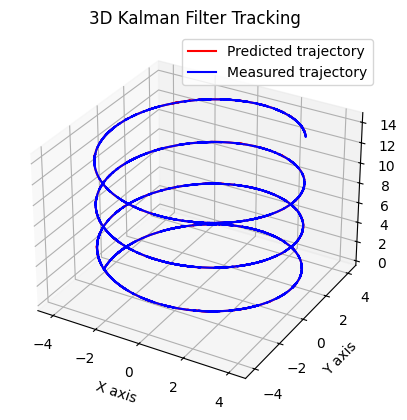

In [340]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(predicted_x, predicted_y, predicted_z, 'r', label='Predicted trajectory')
ax.plot(measured_x, measured_y, measured_z, 'b', label='Measured trajectory')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('3D Kalman Filter Tracking')
ax.legend()

plt.show()